# CONVOLUTIONAL NEURAL NETWORK for detecting vehicles in an image using TensorFlow

_Data is from www.kaggle.com/datasets/brsdincer/vehicle-detection-image-set_

__About Dataset__

non-vehicles: Images containing vehicles.<br>
vehicles: Images not containing vehicles.<br>

Total Number of images: 17760 

__Problem Statement:__<br>
Based on an existing image database of vehicles and non-vehicles, detect whether an image contains a vehicle. 

In [51]:
import numpy as np
import pandas as pd
import os
import time
import random

import matplotlib.pyplot as plt

from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf 
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

## Step 1. Evaluate the dataset.
* File types: Ensure that all files are images.<br>
* Resolutions: Check the resolutions of the images to determine scaling.<br>
* Visualize: Examine random photos.

In [58]:
CHECK_FILETYPES = True
CHECK_RESOLUTIONS = True
VISUALIZE = True

directory_path = '/kaggle/input/vehicle-detection-image-set/data'
subfolder = ['non-vehicles', 'vehicles']

In [48]:
if CHECK_FILETYPES:
    
    file_types = set()
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_extension = os.path.splitext(file)[1]
            file_types.add(file_extension)
            
    print("File types of the images in the dataset:\n",file_types)

File types of the images in the dataset:
 {'.png'}


In [49]:
if CHECK_RESOLUTIONS:
    
    resolutions = set()
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    resolution = img.size
                    resolutions.add(resolution)
            except Exception as e:
                print(f"Error opening image {file}: {e}")
                
    print("Resolutions of the images in the dataset:\n", resolutions)

Resolutions of the images in the dataset:
 {(64, 64)}


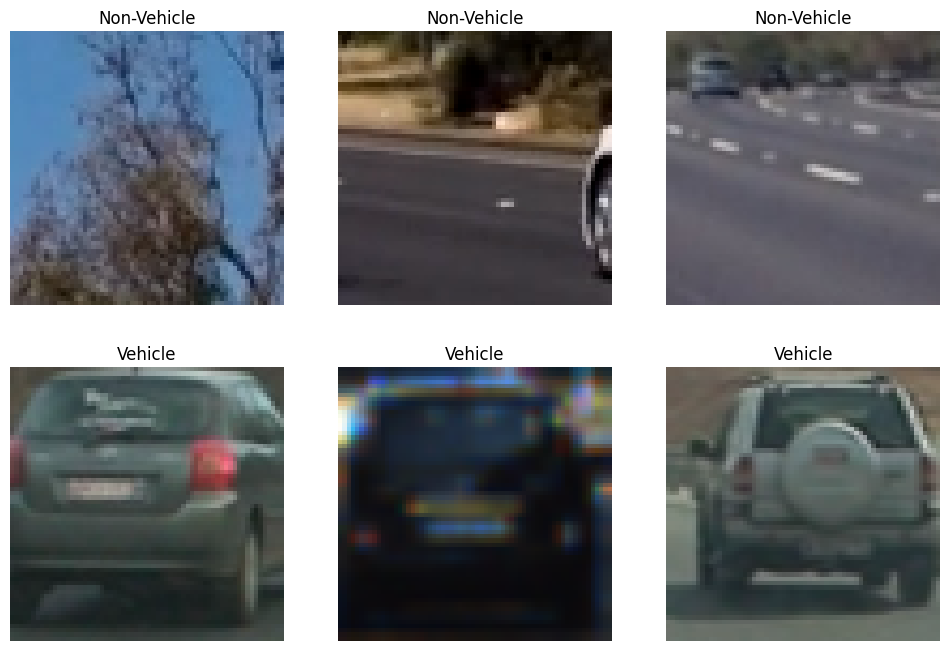

In [65]:
def load_and_preprocess_image(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0
    return image

subfolder = ['non-vehicles', 'vehicles']
if VISUALIZE:
    plt.figure(figsize=(12, 8))
    for j, subfolder in enumerate(subfolder):
        folder_path = os.path.join(directory_path, subfolder)
        image_files = random.sample(os.listdir(folder_path), 3)
        
        for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            image = load_and_preprocess_image(image_path).numpy()

            plt.subplot(2, 3, j * 3 + i + 1)
            plt.imshow(image)
            plt.title('Vehicle' if subfolder == 'vehicles' else 'Non-Vehicle')
            plt.axis('off')

    plt.show()

## Step 2. Create training, validation, and test sets.
* Test split: 80-20<br>
* Validation split: 80-20

In [71]:
# Variables to store total counts
m_nonvehicles = 0
m_vehicles = 0

split_test = 0.2
split_valid = 0.2

# Count images in each category
subfolder = ['non-vehicles', 'vehicles']
for subfolder in subfolder:
    path = os.path.join(directory_path, subfolder)
    if os.path.exists(path):
        if subfolder == 'non-vehicles':
            m_nonvehicles = len(os.listdir(path))
        elif subfolder == 'vehicles':
            m_vehicles = len(os.listdir(path))

m = m_nonvehicles + m_vehicles
n_test = round(m * split_test)
n_train = round((m - m * split_test) * (1 - split_valid))
n_valid = round((m - m * split_test) * (split_valid))

n_test_non = round(m_nonvehicles * split_test)
n_train_non = round(m_nonvehicles * (1 - split_test) * (1 - split_valid))
n_valid_non = round(m_nonvehicles * (1 - split_test) * (split_valid))

n_test_vehicle = round(m_vehicles * split_test)
n_train_vehicle = round(m_vehicles * (1 - split_test) * (1 - split_valid))
n_valid_vehicle = round(m_vehicles * (1 - split_test) * (split_valid))

print(f"Number of images in the dataset: {m}\n")
print('-'* 73)
print(f"{'Category':<20}{'Total':<10}{'Train':<10}{'Validate':<10}{'Test':<10}{'Test Split(%)':<10}")
print('-'* 73)
print(f"{'Non-vehicle':<20}{m_nonvehicles:<10}{n_train_non:<10}{n_valid_non:<10}{n_test_non:<10}{n_test_non/(n_valid_non+n_train_non+n_test_non):<4.4}")
print(f"{'Vehicle':<20}{m_vehicles:<10}{n_train_vehicle:<10}{n_valid_vehicle:<10}{n_test_vehicle:<10}{n_test_vehicle/(n_valid_vehicle+n_train_vehicle+n_test_vehicle):<4.4}")
print('-'* 73)
print(f"{'':<20}{m:<10}{n_train:<10}{n_valid:<10}{n_test:<10}{n_test/(n_valid+n_train+n_test):<4.4}")

Number of images in the dataset: 17760

-------------------------------------------------------------------------
Category            Total     Train     Validate  Test      Test Split(%)
-------------------------------------------------------------------------
Non-vehicle         8968      5740      1435      1794      0.2 
Vehicle             8792      5627      1407      1758      0.2 
-------------------------------------------------------------------------
                    17760     11366     2842      3552      0.2 


In [41]:
vehicle_dir = os.path.join(directory_path, 'vehicles')
non_vehicle_dir = os.path.join(directory_path, 'non-vehicles')

vehicle_files = [os.path.join(vehicle_dir, f) for f in os.listdir(vehicle_dir)]
non_vehicle_files = [os.path.join(non_vehicle_dir, f) for f in os.listdir(non_vehicle_dir)]

# Create labels
vehicle_labels = ["1"] * len(vehicle_files)
non_vehicle_labels = ["0"] * len(non_vehicle_files)

# Combine data
all_files = vehicle_files + non_vehicle_files
all_labels = vehicle_labels + non_vehicle_labels

# Split into training and test sets (0.2 test split)
train_files, test_files, train_labels, test_labels = train_test_split(all_files, all_labels, test_size=0.2, random_state=42)

# Create dataframes for train, validation, and test data
train_df = pd.DataFrame({'filename': train_files, 'class': train_labels})
test_df = pd.DataFrame({'filename': test_files, 'class': test_labels})

# Further split training data into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(train_df['filename'], train_df['class'], test_size=0.2, random_state=42)

val_df = pd.DataFrame({'filename': val_files, 'class': val_labels})

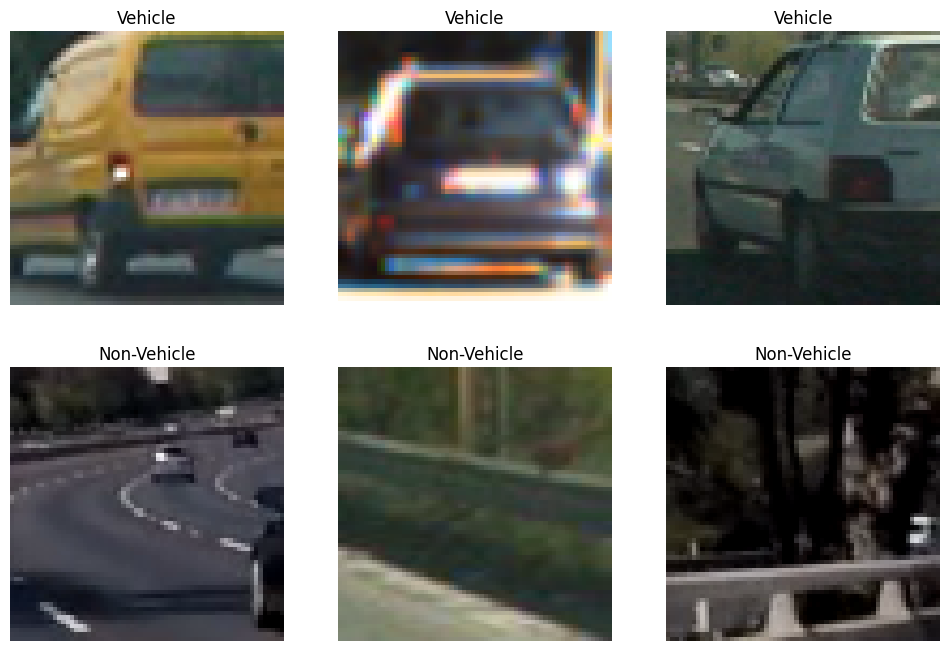

In [42]:
# Confirm that the images were labeled correctly
plt.figure(figsize=(12, 8))
for i, idx in enumerate([1,3,5,2,4,9]):
    image_path = train_files[int(idx)]
    label = int(train_labels[idx])
    image = load_and_preprocess_image(image_path).numpy()
    
    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title('Vehicle' if label == 1 else 'Non-Vehicle')
    plt.axis('off')

plt.show()

__Setup:__<br>
Using Keras ImageDataGenerator:
1. Augmentation of the training data using various image alterations (rotation, shift, tilt, zoom, flip)
2. Conversion of the images to tensors which is readily readable by TensorFlow for fitting.

In [73]:
# ImageDataGenerator for train set with augmented data
datagen_train = ImageDataGenerator( 
    rescale=1./255, 
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest'
)

# ImageDataGenerator for test set
datagen_test = ImageDataGenerator(
    rescale=1./255
)

# Create training data generator
train_generator = datagen_train.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(64, 64), #maintaining the data resolution since it is small
    batch_size=32,
    class_mode='binary',
    seed=42 #of course
)

# Create validation data generator
validation_generator = datagen_train.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    seed=42
)

# Create test data generator
test_generator = datagen_test.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    seed=42
)

# Number of images in the dataset:
# -------------------------------------------------------------------------
# Category            Total     Train     Validate  Test      Test Split(%)
# -------------------------------------------------------------------------
# Non-vehicle         8968      5740      1435      1794      0.2 
# Vehicle             8792      5627      1407      1758      0.2 
# -------------------------------------------------------------------------
#                     17760     11366     2842      3552      0.2 


Found 14208 validated image filenames belonging to 2 classes.
Found 2842 validated image filenames belonging to 2 classes.
Found 3552 validated image filenames belonging to 2 classes.


## Step 3. Design the CNN model.
* Model: The model shall have 4 convolutional layers and 2 dense layers.<br>
* Checkpoints: Save the computed weights after every epoch.<br>
* Stopping: Stop when the fit is not improving after 3 epochs to prevent overfitting.<br>
* Learning rate: 0.0001 and using an Adam Optimizer.<br>
* Epochs: 50, but it is expected to stop earlier.

In [44]:
cnn = models.Sequential([

    layers.Input(shape=(64, 64, 3)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Save every model after every epoch
model_checkpoint = ModelCheckpoint(
    'model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.weights.h5',
    save_weights_only=True,
    save_best_only=False,
    verbose=1
)

# Stop when the fit is not improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=3,
    verbose=1
)

cnn.compile(
    optimizer = Adam(learning_rate=0.0001), 
    loss = 'binary_crossentropy', 
    metrics = ['accuracy']
)

# Start training timer
start_time = time.time()

# Train the model
history = cnn.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 50,
    callbacks = [early_stopping, model_checkpoint]
)

# Show training time 
end_time = time.time()
elapsed_time = end_time - start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Training Time: {int(hours):02}:{int(minutes):02}:{int(seconds):02}")

# Evaluate on the test set
test_loss, test_acc = cnn.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')

Epoch 1/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7748 - loss: 0.4324
Epoch 1: saving model to model_epoch_01_val_loss_0.25.weights.h5
444/444 ━━━━━━━━━━━━━━━━━━━━ 79s 170ms/step - accuracy: 0.7750 - loss: 0.4321 - val_accuracy: 0.9089 - val_loss: 0.2469
Epoch 2/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9307 - loss: 0.1878
Epoch 2: saving model to model_epoch_02_val_loss_0.24.weights.h5
444/444 ━━━━━━━━━━━━━━━━━━━━ 76s 170ms/step - accuracy: 0.9308 - loss: 0.1877 - val_accuracy: 0.9029 - val_loss: 0.2370
Epoch 3/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9496 - loss: 0.1353
Epoch 3: saving model to model_epoch_03_val_loss_0.09.weights.h5
444/444 ━━━━━━━━━━━━━━━━━━━━ 76s 170ms/step - accuracy: 0.9496 - loss: 0.1353 - val_accuracy: 0.9708 - val_loss: 0.0934
Epoch 4/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9660 - loss: 0.1078
Epoch 4: saving model to model_epoch_04_val_loss_0.08.weights.h5
444/444 ━━━━━━━━━━━━━━━━━━━━

## Step 4. Evaluate the model.

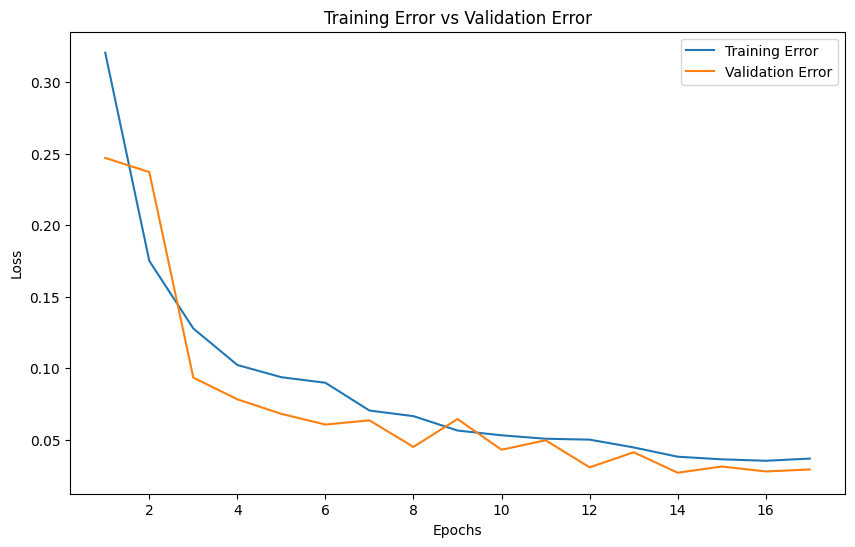

In [46]:
# Extracting loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting the training error vs validation error
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Error')
plt.plot(epochs, val_loss, label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Error vs Validation Error')
plt.legend()
plt.show()

__Training Error vs Validation Error__<br>
The graph above shows that training and validation errors decreased steadily and did not start to diverge, hence the model is not overfitted.

In [45]:
# Load the best model
best_model = load_model('best_model.keras')

# Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9911 - loss: 0.0287
Test Loss: 0.0265
Test Accuracy: 0.9921


### Test Accuracy = 99.21%